In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import constants, signal
from scipy.signal import hilbert, chirp
from scipy.fft import fft, fftfreq, fftshift

from pathlib import Path

Having explored methods of filtering and noise analysis, we can put everything together, and consider a method extract the ring down time of a signal using the analytic signal.  

As an example, we will synthesize a noisey signal.

In [10]:
def test_exp(amplitude=100, noise=0.001):
    """Generate a decaying sine squared function, with decay time tau = 0.3 seconds. 
    
    Args: 
        noise (float): the amplitude noise in the signal, in units of V squared per Hz 
    """
    tau = 0.3
    f0 = 1000
    DC = 200
    fs = 50e3
    nt = int(np.ceil(2*fs))
    sn_rms = noise * fs / 2
    
    dt = 1/fs
    t = dt*np.arange(nt)
    
    rng = np.random.default_rng()
    # phase_noise = rng.uniform(low = -np.pi/6, high = np.pi/6, size = nt)
    amplitude_noise = np.random.normal(0, sn_rms, t.size)

    phase_noise = 0

    y = (amplitude)*(np.sin(2*np.pi*f0*t + phase_noise)**2) * \
        np.exp(-t/tau) + DC + amplitude_noise

    return t, y, fs


Text(0, 0.5, 'Voltage (V)')

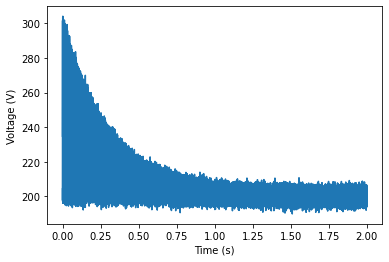

In [114]:
t, y, fs = test_exp(amplitude = 100, noise=0.0001)
# plot the noisy signal in the time domain 
plt.plot(t, y)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

Text(0, 0.5, 'Voltage (V)')

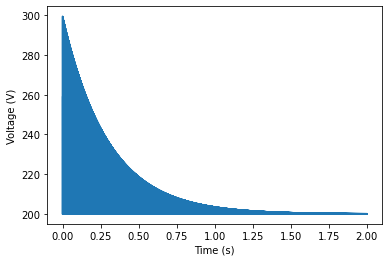

In [115]:
# plot the noise-free signal in the time domain 
t, y, fs = test_exp(amplitude = 100, noise = 0)
plt.plot(t, y)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

Let's consider the noisy signal again, and this time in the frequency domain. 

Text(0, 0.5, 'Noise Spectral Density, $\\mathit{S}_{xx}$ (V$^{2}$/Hz)')

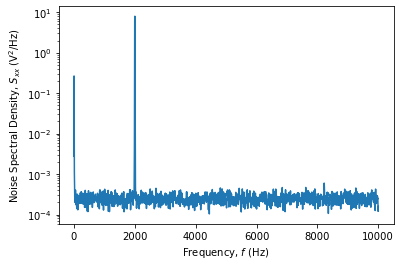

In [117]:
t, y, fs = test_exp(amplitude = 100, noise=0.0001)

f, Pxx_den = signal.welch(y, fs, window=signal.windows.hann(10*1024,))
plt.semilogy(f[f<=10e3], Pxx_den[f<=10e3])
plt.xlabel("Frequency, $\mathit{f}$ (Hz)")
plt.ylabel("Noise Spectral Density, $\mathit{S}_{xx}$ (V$^{2}$/Hz)")

Let's apply a band pass filter of order 1, and band width 200 about the signal frequency. Since we are applying a band pass filter, this will remove any DC component in the signal too.

Text(0, 0.5, 'Voltage (V)')

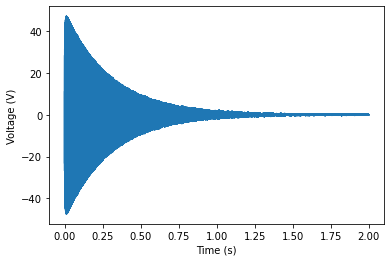

In [118]:
f0 = 2e3
bw = 100

cutoffs = (f0 - bw/2, f0 + bw/2)
sos = signal.butter(1, cutoffs, btype='bandpass', output = "sos", fs = fs)

y_bp = signal.sosfiltfilt(sos, y)

# plot the filtered
plt.plot(t, y_bp)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

Then, we perform the envelop extraction. The method we use relies on finding the analytic signal of via the hilber transform. The analytic signal also gives us information about the instantaneous phase and frequency of the signal. 

In [119]:
analytic_s = signal.hilbert(y_bp)
amp_env = np.abs(analytic_s)
phase = np.unwrap(np.angle(analytic_s))
freq = (np.diff(phase) / (2.0*np.pi) * fs)

We plot the extracted envelop using the plot below. We see that there's some artifacts near the beginning and end of the signal, which we can remove using a mask, or directly discard. 

Let's discard the first 350 points, and the last 10 points in the extracted envelop, using the syntax: 
```
350:-10
```

Text(0, 0.5, 'Voltage (V)')

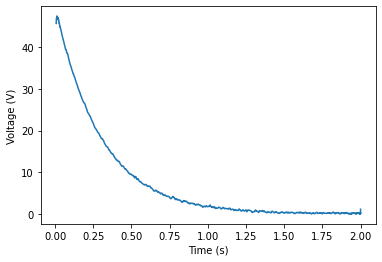

In [124]:
plt.plot(t[350:-10], amp_env[350:-10])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")

### Fitting and parameter extraction

In [125]:
from lmfit import Model, Parameters, minimize, report_fit

Let's fit the extracted envelope to an exponential decay using the method of non-linear least squares.

In [126]:
def decay(t, A, tau):
    return A*np.exp(-t/tau)

model = Model(decay, independent_vars=['t'])
# result = model.fit(data, t=t, N=10, tau=1)

params = model.make_params()

params["A"].value = 1
params["A"].min = 0.0

params["tau"].value = 0.1
params["tau"].min = 0.0

In [127]:
result = model.fit(amp_env[200:-2], params, t=t[200:-2], method = "leastsq")
result

Concisely, we can the decay time by calling

In [128]:
result.params["tau"]

<Parameter 'tau', value=0.30189025725188356 +/- 3.58e-05, bounds=[0.0:inf]>

Using this method of extraction, we seem to be off by around 0.3 percent. 

In [130]:
(result.params["tau"].value - 0.3)/(result.params["tau"].value + 0.3)

0.003140534722250084

If we try to directly fit the entire ring down curve, it seems like we get a worst estimate of the ring down time. 

In [134]:
def decay(t, A, tau, f0, DC):
    return A*np.sin(2*np.pi*f0*t) * \
        np.exp(-t/tau) + DC

model = Model(decay, independent_vars=['t'])
params = model.make_params()

params.add('A', value=45, min = 0)
params.add('tau', value=0.3, min = 0)
params.add('f0', value=2e3)
params.add('DC', value=0, vary = False)

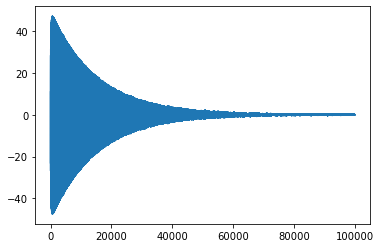

In [135]:
plt.plot(y_bp)

In [136]:
result = model.fit(y_bp[200:-2], params, t=t[200:-2], method = "leastsq")
result

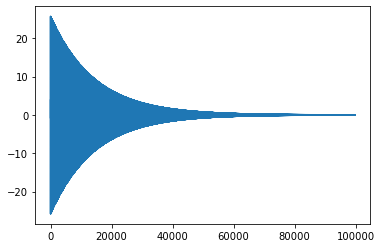

In [137]:
plt.plot(result.best_fit)